<a href="https://colab.research.google.com/github/gogooma9/SolarGen/blob/gbm/src/solar_gen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import os
import glob
import random

import warnings
warnings.filterwarnings("ignore")

data_path = '/content/drive/MyDrive/SolarGen/'

## Baseline

In [ ]:
train = pd.read_csv(data_path + './data/train/train.csv')
submission = pd.read_csv(data_path + './data/sample_submission.csv')

In [ ]:
from sklearn.neighbors import LocalOutlierFactor
import scipy.interpolate as interpolate


def LOF(data, neighbors = 20 ,conta =0.01):
    temp = data.copy()
    temp = temp[['DHI', 'DNI']]

    clf = LocalOutlierFactor(n_neighbors = neighbors, contamination = conta , p = 2)
    y_pred = clf.fit_predict(temp)

    return y_pred

#p = 1 or 2
#neighbors
#conta
#number of variables

train_afterLOF = pd.DataFrame(LOF(train, 20, 0.005))

outlier_idx = train_afterLOF[train_afterLOF[0] < 1].index
print(len(outlier_idx))

train.drop(outlier_idx, axis=0, inplace=True)

new_idx = [i for i in range(0,52560)]
added_idx_train = train.reindex(new_idx)
train = added_idx_train.interpolate(method = 'linear',limit_direction='forward')
train

263


,Day,Hour,Minute,DHI,DNI,WS,RH,T,TARGET
0,0.0,0.0,0.0,0.0,0.0,1.5,69.08,-12.0,0.0
1,0.0,0.0,30.0,0.0,0.0,1.5,69.06,-12.0,0.0
2,0.0,1.0,0.0,0.0,0.0,1.6,71.78,-12.0,0.0
3,0.0,1.0,30.0,0.0,0.0,1.6,71.75,-12.0,0.0
4,0.0,2.0,0.0,0.0,0.0,1.6,75.20,-12.0,0.0
...,...,...,...,...,...,...,...,...,...
52555,1094.0,21.0,30.0,0.0,0.0,2.4,70.70,-4.0,0.0
52556,1094.0,22.0,0.0,0.0,0.0,2.4,66.79,-4.0,0.0
52557,1094.0,22.0,30.0,0.0,0.0,2.2,66.78,-4.0,0.0
52558,1094.0,23.0,0.0,0.0,0.0,2.1,67.72,-4.0,0.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6b168dee10>,
      dtype=object)

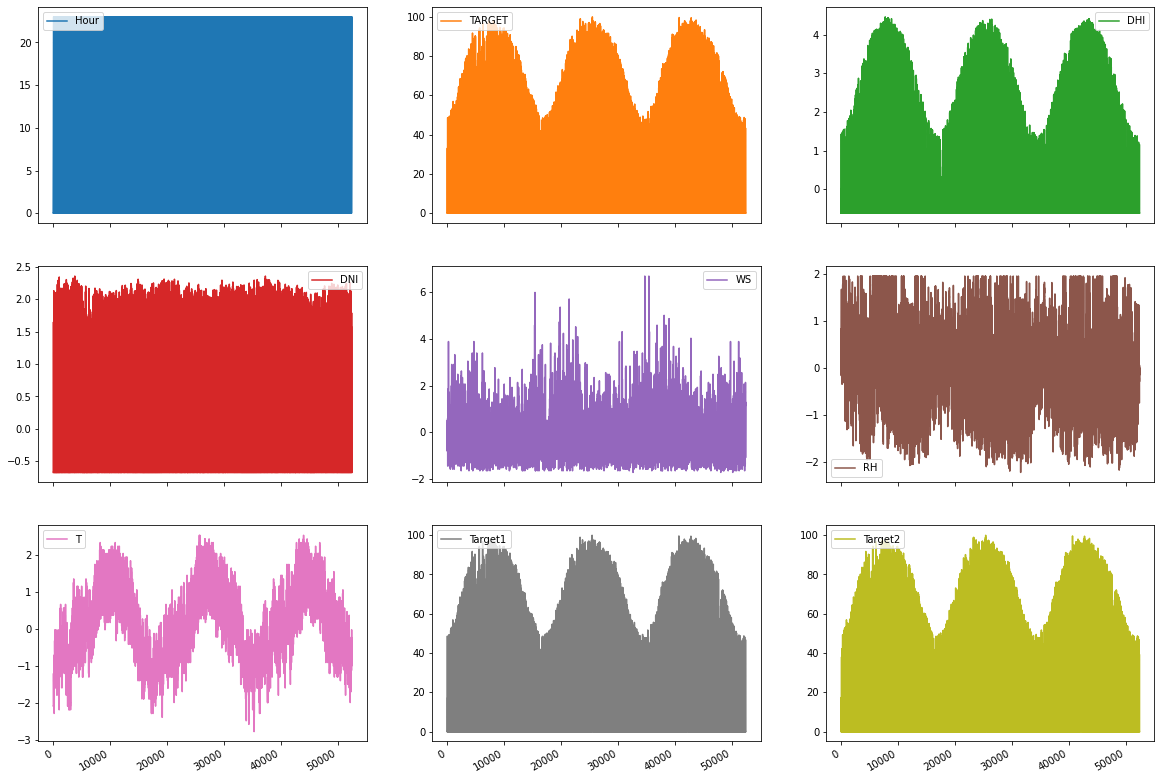

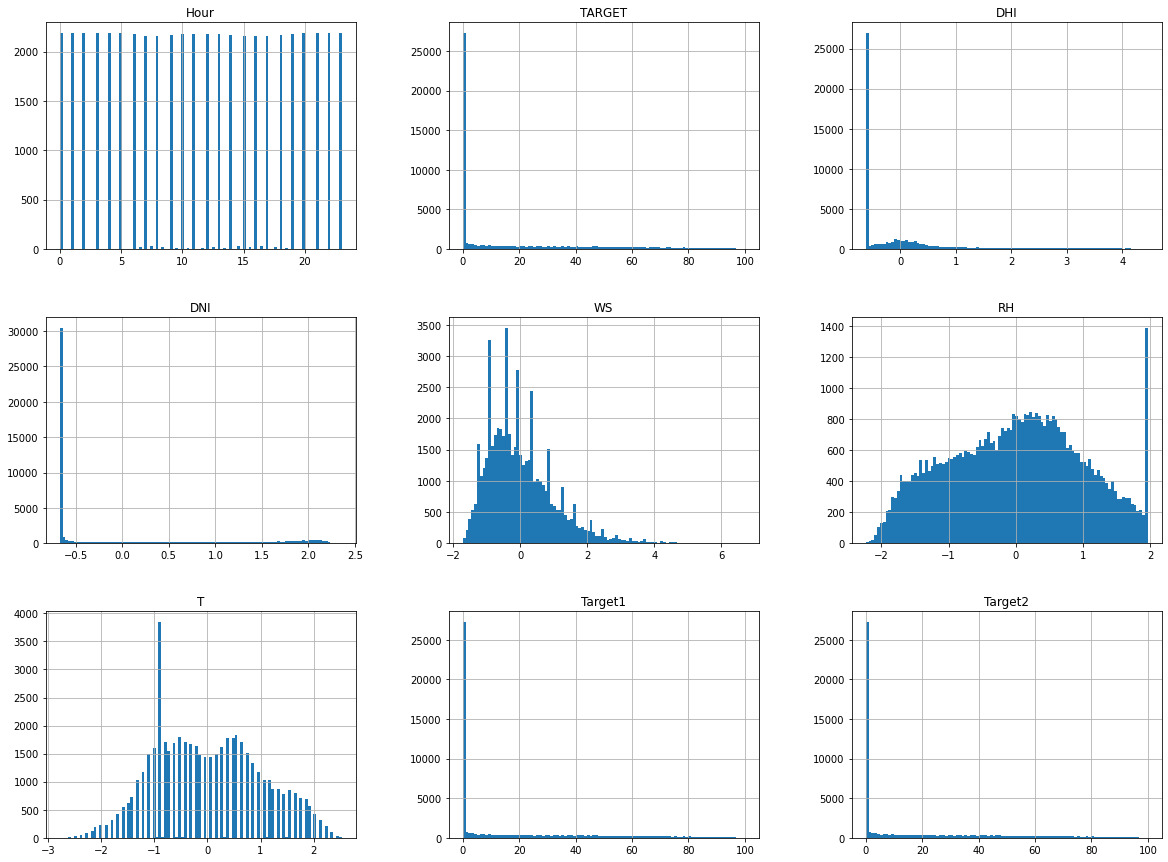

In [ ]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import (
    MinMaxScaler, StandardScaler, RobustScaler, QuantileTransformer, 
    MaxAbsScaler, PowerTransformer
)

def scaling(data, scaler, is_train=True):

    temp = data.copy()

    target_cols = ['DHI', 'DNI', 'WS', 'RH', 'T']
    temp = temp[target_cols]
    if is_train: 
        scaler.fit(temp)
    scaled = scaler.transform(temp)

    data[target_cols] = scaled

    return data     

def preprocess_data(data, scalers, is_train=True):
    
    temp = data.copy()

    for scaler in scalers:
        temp = scaling(temp, scaler, is_train)

    temp = temp[['Hour', 'TARGET', 'DHI', 'DNI', 'WS', 'RH', 'T']]

    if is_train==True:          
    
        temp['Target1'] = temp['TARGET'].shift(-48).fillna(method='ffill')
        temp['Target2'] = temp['TARGET'].shift(-48*2).fillna(method='ffill')
        temp = temp.dropna()
        
        return temp.iloc[:-96]

    elif is_train==False:
        
        temp = temp[['Hour', 'TARGET', 'DHI', 'DNI', 'WS', 'RH', 'T']]
                              
        return temp.iloc[-48:, :]

scalers = []
# scalers.append(MinMaxScaler())
scalers.append(StandardScaler())
# scalers.append(RobustScaler())
# scalers.append(MaxAbsScaler())
# scalers.append(QuantileTransformer(n_quantiles=900))
# scalers.append(PowerTransformer(method='yeo-johnson'))
# scalers.append(PowerTransformer(method='box-cox'))

df_train = preprocess_data(train, scalers)
df_train.plot(subplots=True, layout=(3,3), figsize=(20,15))
df_train.hist(bins = 100, figsize=(20,15))

In [ ]:
df_test = []

for i in range(81):
    file_path = data_path + './data/test/' + str(i) + '.csv'
    temp = pd.read_csv(file_path)
    temp = preprocess_data(temp, scalers, is_train=False)
    df_test.append(temp)

X_test = pd.concat(df_test)
X_test.shape

(3888, 7)

In [ ]:
from sklearn.model_selection import train_test_split
X_train_1, X_valid_1, Y_train_1, Y_valid_1 = train_test_split(df_train.iloc[:, :-2], df_train.iloc[:, -2], test_size = 0.2, random_state=0)
X_train_2, X_valid_2, Y_train_2, Y_valid_2 = train_test_split(df_train.iloc[:, :-2], df_train.iloc[:, -1], test_size = 0.2, random_state=0)

In [ ]:
quantiles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

In [ ]:
# from sklearn.ensemble import GradientBoostingRegressor

# Get the model and the predictions in (a) - (b)
# def GBM(q, X_train, Y_train):
    
  #  (a) Modeling  
  #  mod = GradientBoostingRegressor(random_state=1, alpha=q, loss='quantile', verbose=1, max_features = 'auto',
                                # n_estimators=2000, max_depth=25, learning_rate=0.027)
  #  mod.fit(X_train, Y_train)

  #  return mod

# def train_data(X_train, Y_train, X_test):

    # GBM_models=[]
    # GBM_actual_pred = pd.DataFrame()

    # for q in quantiles:
        # model = GBM(q, X_train, Y_train)
        # GBM_models.append(model)

        # pred = pd.Series(model.predict(X_test).round(2))
        # GBM_actual_pred = pd.concat([GBM_actual_pred,pred],axis=1)

    # GBM_actual_pred.columns=quantiles

    # return GBM_models, GBM_actual_pred

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV


# Get the model and the predictions in (a) - (b)
def GBM(q, X_train, Y_train):
    
   # (a) Modeling  
   mod = GradientBoostingRegressor(random_state=1, alpha=q, loss='quantile', verbose=1, max_features = 'auto')

   param_grid = [{'n_estimators' : range(500,2900,300), 'max_depth' : range(3,10), 
                  'learning_rate' : np.linspace(0.001, 0.03, 30)}]
                  
   grid_search = GridSearchCV(estimator = mod, param_grid = param_grid,
                              scoring = 'neg_mean_squared_error',cv=5, n_jobs = -1)
   grid_search.fit(X_train, Y_train)
   print(grid_search.best_params_)
   print(grid_search.best_score_)

   mod = grid_search.best_estimator_


   return mod

def train_data(X_train, Y_train, X_test):

    GBM_models=[]
    GBM_actual_pred = pd.DataFrame()

    for q in quantiles:
        model = GBM(q, X_train, Y_train)
        GBM_models.append(model)

        pred = pd.Series(model.predict(X_test).round(2))
        GBM_actual_pred = pd.concat([GBM_actual_pred,pred],axis=1)

    GBM_actual_pred.columns=quantiles

    return GBM_models, GBM_actual_pred

In [ ]:
# Scores
def Scores(GBM_models, X_valid, Y_valid):

    score_record = []
    for i in range(0,9):

        score_record.append(GBM_models[i].score(X_valid, Y_valid))

        print("[%.1f]"%quantiles[i] + "\t%f"%score_record[i])
    print("[avg]\t%.6f"%np.average(score_record))

In [ ]:
GBM_models_1, results_1 = train_data(X_train_1, Y_train_1, X_test)
Scores(GBM_models_1,X_valid_1, Y_valid_1)


In [ ]:
GBM_models_2, results_2 = train_data(X_train_2, Y_train_2, X_test)
Scores(GBM_models_2,X_valid_2, Y_valid_2)

In [ ]:
results_1 = results_1.clip(0.0)
results_2 = results_2.clip(0.0)

In [ ]:
submission.loc[submission.id.str.contains("Day7"), "q_0.1":] = results_1.values
submission.loc[submission.id.str.contains("Day8"), "q_0.1":] = results_2.values
submission

In [ ]:
submission.to_csv(data_path + './data/submission.csv', index=False)